url :

https://www.naval-group.com/en/documents

In [1]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import pandas as pd,requests,bs4,re,time,io,pytesseract,easyocr,random,textstat,urllib.request
from pdfminer.high_level import extract_text
from PIL import Image
from pathlib import Path
from pdf2image import convert_from_path
from selenium.webdriver.common.by import By
from goose3 import Goose
from datetime import datetime
from bs4 import BeautifulSoup
from selenium import webdriver

reader = easyocr.Reader(['en'])

import warnings
warnings.filterwarnings("ignore")

%autosave 1

Autosaving every 1 seconds


In [2]:
#driver for operation
from webdriver_manager.chrome import ChromeDriverManager
option = webdriver.ChromeOptions()
option.add_argument('headless')
driver = webdriver.Chrome(ChromeDriverManager().install(),options=option)



====== WebDriver manager ======
Current google-chrome version is 102.0.5005
Get LATEST chromedriver version for 102.0.5005 google-chrome
Driver [C:\Users\AKSHAY SATPUTE\.wdm\drivers\chromedriver\win32\102.0.5005.61\chromedriver.exe] found in cache


In [3]:
SITE_NAME='Naval-group'

DOMAIN = "https://www.naval-group.com"

SITE_LINK="https://www.naval-group.com/en/documents"

In [4]:
def parse_webpage_bs(search_url):
    
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:90.0) Gecko/20100101 Firefox/90.0"}
    try:
        site_request = requests.get(search_url, headers=headers, timeout=10)
    except requests.exceptions.RequestException as e:
        print(e)
        site_request = None
    if site_request != None and site_request.status_code==200:
        site_soup = bs4.BeautifulSoup(site_request.content, "lxml")
    else:
        site_soup = None
    return site_soup

def remove_esc_chars(text):
    return text.replace("\n", " ").replace("\t", " ").replace("\r", " ")

def get_text(link): 
    g = Goose()
    article_extract = g.extract(url=link)
    article = remove_esc_chars(article_extract.cleaned_text)
    meta_data = remove_esc_chars(article_extract.meta_description)
    whole_data = meta_data+article
    text = whole_data.strip()

    if textstat.lexicon_count(text, removepunct=True) < 5:
        try:
            response = requests.get(link)
            text = remove_esc_chars(extract_text(io.BytesIO(response.content)))

            if textstat.lexicon_count(text, removepunct=True) < 5:
                texts = ""
                r = requests.get(link)
                filename = Path('temp.pdf')
                filename.write_bytes(r.content)

                pages = convert_from_path('temp.pdf', 500)
                for x in pages:
                    x.save("temp.jpg")
                    output = reader.readtext("temp.jpg")
                    for o in output:
                        texts += o[1]

                text = remove_esc_chars(texts)

                if textstat.lexicon_count(text, removepunct=True) < 5:
                    texts = ""
                    soup = parse_webpage_bs(link)
                    if soup!= None:
                        ps = soup.findAll('p')
                        for p in ps:
                            texts+= p.text

                    text = remove_esc_chars(texts)
        except:
            text = ""
    
    return text

In [5]:
article_list = []

pagination = 0
last_page = 0

while pagination <= last_page:
    url = f"https://www.naval-group.com/en/documents?page={pagination}"
    driver.get(url)
    
    #accepting cookies
    try:
        driver.find_element(By.XPATH,'''//*[@id="orejime"]/div[1]/div/div/div/ul/li[1]/button''').click()
    except:
        pass

    #getting last page count
    if last_page <= 1:
        lp = driver.find_element(By.XPATH,'''//*[@id="block-mainpagecontent"]/div[2]/div/nav/ul/li[2]''').text.split("\n")[1]
        last_page_count = int(lp.strip())
        last_page = last_page_count - 1

    elements = driver.find_elements(By.XPATH,'''//li[@role="article"]''')
    
    #creating empty lists to append data 
    published_dates,titles,texts,links,thumbnails,authors = [],[],[],[],[],[]
    
    #links,thumbnails,authors
    for e in range(1,len(elements)):
        thumbnail = "https://upload.wikimedia.org/wikipedia/commons/8/8a/Naval_Group_Logo.png"
        thumbnails.append(thumbnail)
        link = driver.find_element(By.XPATH,f'''/html/body/div[2]/div/main/div[2]/div[2]/div[2]/div/ul/li[{e}]/div/div[2]/a''').get_attribute("href")
        links.append(link)
        authors.append(SITE_NAME)

    #published_dates,titles,texts
    for link in links[:3]:
        driver.get(link)
        published_date =  driver.find_element(By.XPATH,'''//*[@id="block-headerblock"]/div/div[3]/p/span[1]''').text.strip()
        published_dates.append(published_date)
        title = driver.find_element(By.XPATH,'''//*[@id="block-headerblock"]/div/div[1]/h1''').text.strip()
        titles.append(title)
        doc_link = driver.find_element(By.XPATH,'''//*[@id="block-socialsharedocumentblock"]/div/div[2]/p/a''').get_attribute("href")
        text = get_text(doc_link)
        if textstat.lexicon_count(text, removepunct=True) < 5: 
            soup = parse_webpage_bs(link)
            ps = soup.find('div',{'id' :'block-mainpagecontent'}).text.strip()
            text = remove_esc_chars(ps).strip()
        texts.append(text)
        print(published_date,title)
        
    #zippig all the data togather 
    zipped = list(zip(published_dates,titles,texts,links,thumbnails,authors))

    #unwinding and appending to the main list
    for published_date,title,text,link,thumbnail,author in zipped:
        article = (published_date.strip(),title.strip(),text.strip(),link.strip(),thumbnail.strip(),author.strip())
        article_list.append(article)
        
    pagination +=1

09 JUNE 2022 Corporate social responsibility report 2021
20 MAY 2022 Suppliers - purchasing - quality requirements and forms
17 MAY 2022 Yearbook 2021
01 SEPTEMBER 2020 Compliance code of conduct (spanish)
01 SEPTEMBER 2020 Compliance code of conduct (arabic)
01 SEPTEMBER 2020 Compliance programme key procedures


In [6]:
temp_df = pd.DataFrame(article_list,columns=['date','title','article','url','thumbnail','author'])
temp_df.head()

,date,title,article,url,thumbnail,author
0,09 JUNE 2022,Corporate social responsibility report 2021,CORPORATE SOCIAL RESPONSIBILITY REPORT ...,https://www.naval-group.com/en/corporate-socia...,https://upload.wikimedia.org/wikipedia/commons...,Naval-group
1,20 MAY 2022,Suppliers - purchasing - quality requirements ...,"File containing general purchasing conditions,...",https://www.naval-group.com/en/suppliers-purch...,https://upload.wikimedia.org/wikipedia/commons...,Naval-group
2,17 MAY 2022,Yearbook 2021,3 NAVAL YEAR BOOK 2021 GROUP CONTENTS ...,https://www.naval-group.com/en/yearbook-2021,https://upload.wikimedia.org/wikipedia/commons...,Naval-group
3,01 SEPTEMBER 2020,Compliance code of conduct (spanish),"CÓDIGO DE CONDUTA COMPLIANCE DIREÇÃO ÉTICA,...",https://www.naval-group.com/en/compliance-code...,https://upload.wikimedia.org/wikipedia/commons...,Naval-group
4,01 SEPTEMBER 2020,Compliance code of conduct (arabic),يقلاخلأا كولسلا طباوض قاثيم ةديشرلا ةرادل...,https://www.naval-group.com/en/compliance-code...,https://upload.wikimedia.org/wikipedia/commons...,Naval-group


01 SEPTEMBER 2020 Compliance programme key procedures

Naval-group https://www.naval-group.com/en/compliance-programme-key-procedures


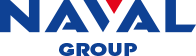


NON-SENSITIVE   COMPLIANCE PROGRAM   -KEY PROCEDURES-   © Property of Naval Group SA 2019 - all rights reserved.   This document/software, in both form and content, is the property of Naval Group and/or third parties. Any use, reproduction, modification, translation,  communication or representation, in whole or in part, of this document/software without the prior written consent of Naval Group is strictly prohibited. Any such  unauthorized use, reproduction, modification, translation, communication or representation, in whole or in part, by any means whatsoever, would constitute an  infringement under civil and criminal law and, more generally, an infringement of Naval Group's rights.                         NON-SENSITIVE   Introduction    As  part  of  its  compliance  program  designed  to  combat  corruption  and  influence  peddling, Naval Group has developed a document repository consisting of a set of  policies, codes and procedures. This repository is applicable to any employ

In [7]:
def see_data(iloc_no=random.randint(0,len(temp_df))-1):
    print(temp_df.iloc[iloc_no]['date'],temp_df.iloc[iloc_no]['title'])
    print(f"\n{temp_df.iloc[iloc_no]['author']} {temp_df.iloc[iloc_no]['url']}")
    urllib.request.urlretrieve(temp_df.iloc[iloc_no]['thumbnail'], "temp.jpg")
    display(Image.open("temp.jpg"))
    print(f"\n{temp_df.iloc[iloc_no]['article']}")

see_data()

In [8]:
#to csv
temp_df.to_csv(f'{SITE_NAME} news.csv',index = False)

#to json
temp_df.to_json(f'{SITE_NAME} news.json')

In [9]:
#to get rid of unwanteed trash created by the model use 
def remove_trash():
    try:
        try:
            os.remove("temp.pdf")
        except:
            pass
        os.remove("temp.jpg")
        print("Trash removed successfully")
    except:
        print("No trash found")

remove_trash()

Trash removed successfully
